## Advances
User files a loan application1 (id)
The Bank approves the application on Date = underwritten_at 
The Bank send the (amount) to the user_id on Date = disbursed_at
One user can get many loans over time.
Total loan provided to a user, total_per_user = advances.groupby('user_id')['amount'].sum()

## Transactions
user_id performa a debit/credit transaction (id)


## Balances
Funds currently avaiable (available_balance) with the user_id as on Date= updated_at.
Current Balance includes pending transactions (not real money yet).
Available Balance is what they can actually spend. Always use the balance from before the loan decision. 
Use the last balance before the loan decision.

Simple Risk Rules:
Balance < $0 → High Risk
Balance between $0 and loan amount → Medium Risk
Balance > loan amount → Low Risk
Example (Loan = $25):
Balance -$10 → High Risk
Balance $0 → High Risk
Balance $15 → Medium Risk
Balance $50 → Low Risk
Balance $100 → Low Risk

## Labels
Links to each advance for a loan application (advance_id)
Was the amt fully repaid in 30 days? repaid_full_30d
% of amt rpaid in 30days = repaid_pct_30d
days_to_first_repay = it’s binary code.
How to Fix It:
Use Python to decode it. When you decode it, you get 3 numbers:
Position: 1st 2nd 3rd
Numbers: (0, 6, 28342991)
Ignore the 1st and 3rd numbers. The 2nd number is the number of days.
Real Example:
Raw data: b'\x00\x00\x00\x00\x06\x00\x00\x00\xcfz\xb0\x01'
After decoding: (0, 6, 28342991)
Days to first repay: 6 days 

If repaid_pct_30d >= 1.0 → repaid_full_30d = True (good)
If repaid_pct_30d < 1.0 → repaid_full_30d = False (bad)

## Application
Contains the app_id for all advances.

**Goal:** Predict 30-day repayment for FIRST-TIME borrowers only.

**IMPORTANT CRITERIA:**
- Only look at **first-time advances** (user's first loan ever)
- Predict: Will they pay back within 30 days?
- Measure: `repaid_full_30d` (True/False)

**The Process:**

**STEP 1: Start with one loan**
- Look at the ADVANCES table
- Pick one row = one loan to predict
- Example: User wants to borrow $25 on March 22

**STEP 1a: Check if this is their FIRST loan**
- Count how many loans this `user_id` has in ADVANCES table
- Filter: Only keep loans where this is the user's FIRST advance
- Skip this loan if they've borrowed before

**STEP 2: Find out what happened (30-day repayment) **
- Go to LABELS table
- Match: `labels.advance_id` = `advances.request_id`
- Look at: `repaid_full_30d` (True/False)
- This tells you: Did they pay back FULLY within 30 days?

**STEP 3: Find the person**
- Get the `user_id` from the advances table
- Now you know WHO borrowed the money

**STEP 4: Look at their spending history**
- Go to TRANSACTIONS table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use transactions from BEFORE the loan date
- Count: How many times did they spend money?
- Calculate: What's their average spending?
- Look: What do they buy? (groceries, loan payments, etc.)

**STEP 5: Check their bank balance**
- Go to BALANCES table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use balances from BEFORE the loan date
- Get the most recent balance
- Check: Is their balance positive or negative?
- See: Is their balance going up or down over time?

**STEP 6: Put it all together**
- Combine all the information for this one FIRST-TIME loan:
  - This is their first loan: Yes
  - Loan amount: $25
  - Their balance: $63
  - Number of transactions: 491
  - They pay other loans: Yes
  - Balance is positive: Yes

**STEP 7: Make a prediction**
- Predict: Will they pay back FULLY within 30 days?
- Then check `repaid_full_30d` in LABELS to see if you were right!

**STEP 8: Measure precision**
- For all first-time loans you predicted "Yes, they'll pay back":
  - Count how many actually paid back (True Positives)
  - Count how many did NOT pay back (False Positives)
  - Precision = True Positives / (True Positives + False Positives)

**Repeat for all FIRST-TIME loans in the dataset.**

In [ ]:
# Read csv

import pandas as pd
import numpy as np
import struct
import os

# Path to your folder
base_path = r"C:/Users/som/Desktop/CourseSem1/AlternativeData/Assignment/MiniProject/Git"                             

# Load your CSVs
df_adv = pd.read_csv(os.path.join(base_path, "Advances.csv"))
df_app = pd.read_csv(os.path.join(base_path, "Applications.csv"))
df_bal = pd.read_csv(os.path.join(base_path, "Balances.csv"))
df_lab = pd.read_csv(os.path.join(base_path, "Labels.csv"))
df_txn = pd.read_csv(os.path.join(base_path, "Transactions.csv"))

#print(" Files loaded successfully")

In [22]:
df_bal.columns

Index(['user_id', 'updated_at', 'available_balance', 'current_balance'], dtype='object')

**STEP 1: Start with one loan**
- Look at the ADVANCES table
- Pick one row = one loan to predict
- Example: User wants to borrow $25 on March 22

**STEP 1a: Check if this is their FIRST loan**
- Count how many loans this `user_id` has in ADVANCES table
- Filter: Only keep loans where this is the user's FIRST advance
- Skip this loan if they've borrowed before

**STEP 2: Find out what happened (30-day repayment) **
- Go to LABELS table
- Match: `labels.advance_id` = `advances.request_id`
- Look at: `repaid_full_30d` (True/False)
- This tells you: Did they pay back FULLY within 30 days?

In [31]:
# ADVANCES

# ensure underwritten_at is a datetime type
df_adv['underwritten_at'] = pd.to_datetime(df_adv['underwritten_at'])

# get first entry per user based on underwritten_at
first_entries = df_adv.sort_values('underwritten_at').drop_duplicates('user_id', keep='first')
# first_entries.to_csv('cleaned_advances.csv', index=False)

# create column for total loan amount per user
first_entries['total_loan_per_user'] = df_adv.groupby('user_id')['amount'].transform('sum')
#print (first_entries.head())
print(first_entries.shape)
# Verify the results
#print(f"Original dataframe: {len(df_adv)} rows")
#print(f"First entries dataframe: {len(first_entries)} rows")
#print(f"Unique users in original: {df_adv['user_id'].nunique()}")
#print(f"Users in first entries: {len(first_entries)}")

# LABELS

# Decode binary column if present
def decode_days(val):
    if pd.isna(val):
        return None
    try:
        if isinstance(val, str) and val.startswith("b'"):
            val = eval(val)
        nums = struct.unpack("<III", val)
        return nums[1]  # take 2nd number
    except Exception:
        return None

if "days_to_first_repay" in df_lab.columns:
    df_lab["days_to_first_repay_decoded"] = df_lab["days_to_first_repay"].apply(decode_days)

# Create User Profile column based on conditions If repaid_pct_30d >= 1.0 → repaid_full_30d = True (good) If repaid_pct_30d < 1.0 → repaid_full_30d = False (bad)
df_lab.loc[
    (df_lab['repaid_pct_30d'] >= 1.0) & (df_lab['repaid_full_30d'] == True),
    'Usr_Profile'
] = 'good'

df_lab.loc[
    (df_lab['repaid_pct_30d'] < 1.0) | (df_lab['repaid_full_30d'] == False),
    'Usr_Profile'
] = 'bad'
print(df_lab.shape)

# Merge Labels & Advances based on advance_id
# Q: Did they pay back FULLY within 30 days?
merged = first_entries.merge(
    df_lab,
    left_on="request_id",   # from Advances.csv
    right_on="advance_id",  # from Labels.csv
    how="left",
    suffixes=("", "_label")
)

print(merged.shape)
#print(merged['advance_id'].isna().sum())
#df_lab['Usr_Profile'].value_counts()
print(merged.head())
merged.columns

(16691, 6)
(54616, 6)
(16691, 12)
                                          request_id  \
0       b'u\xab>6\xa8\xc7E\xaf\x8c\x85\xd6\t9g\xe5&'   
1    b'\x95\xe6\xb4A\tdH\x8b\x88\xe7P:V\xe8\x9d\xf6'   
2     b'x\x97H\xf6w\x8eE\xab\xafK\xf3\xba\x94\xcb,y'   
3  b'2\x00/\x19\xa7\x7fK\x05\xa9\xb2>\x8a\xdcG\x0...   
4  b':\xb1\x02\x86*vB\xc9\xb4\xd2L\xe3\xe7\xabd\xd5'   

             underwritten_at                disbursed_at  amount  \
0 2024-03-09 18:41:20.327833  2024-03-10 02:01:20.488311    25.0   
1 2024-04-15 21:38:48.312520  2024-04-15 22:39:40.439586    25.0   
2 2024-04-19 07:22:19.237438  2024-04-19 16:20:55.435149    25.0   
3 2024-05-14 20:13:21.452987  2024-05-14 20:14:24.636421    25.0   
4 2024-05-16 22:29:08.763494  2024-05-16 22:31:07.360124    25.0   

                                             user_id  total_loan_per_user  \
0  b"K'~\xaf\xca\xeaHd\x84\x8e\xb9\xa1\x047\xf2\xc9"                300.0   
1    b'\xb8\xe4\xafbn\nJ\xa3\x91\xd0\x9c4\xaf{j\xe3'              

Index(['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id',
       'total_loan_per_user', 'advance_id', 'repaid_full_30d',
       'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded',
       'Usr_Profile'],
      dtype='object')

**STEP 3: Find the person**
- Get the `user_id` from the advances table
- Now you know WHO borrowed the money
**STEP 4: Look at their spending history**
- Go to TRANSACTIONS table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use transactions from BEFORE the loan date

In [3]:
print("df_txn columns:", df_txn.columns.tolist())
print(df_txn.head(3))

df_txn columns: ['id', 'user_id', 'date', 'authorized_date', 'created_at', 'primary_category', 'detailed_category', 'amount', 'merchant_name', 'name', 'original_description']
                                            id  \
0    b'\x13C\\Q:\xf2H7\xafi\x04\xe2\x058\xa1N'   
1  b'lm{i%OB\x16\x8e\xa9\x90\x86\x9cA\xde\x13'   
2  b'\x1cy\x8bT\xc1]E>\xaco\xdd\x029\xff\x19<'   

                                             user_id        date  \
0  b'\xf4.\x83\xfc\t\x1dO\xde\x8aG\xde\x12\xf9\x8...  2025-07-04   
1       b'\xce\xcbvY\xaaaF\xbd\xac=\x15"\t\xf9Q\x7f'  2025-06-12   
2     b'J\xba|:Y\x9dD\xe4\x92G\x0b\xe4C\xa2\xbf\xa2'  2025-07-07   

  authorized_date                  created_at primary_category  \
0      2025-07-04  2025-07-05 19:30:24.269317    ENTERTAINMENT   
1      2025-06-12  2025-07-07 04:37:56.929411   TRANSPORTATION   
2      2025-07-03  2025-07-08 11:04:30.245787   FOOD_AND_DRINK   

                      detailed_category  amount merchant_name  \
0    ENTERTAINMENT_CA

In [9]:
# MERGE Advances, Labels with Transactions for all transactions before underwriting
adv_lab_txn = df_txn.merge(
    merged[['user_id', 'advance_id', 'underwritten_at']],
    on='user_id',
    how='left'
)

# Keep only transactions that occurred before the underwriting decision
adv_lab_txn = adv_lab_txn[adv_lab_txn['date'] < adv_lab_txn['underwritten_at']]

#for each advance_id, aggregate those pre-loan transactions
#Features created txn_count: How many times did they spend money?  txn_total, txn_avg: What's their average spending? 
agg_txn = adv_lab_txn.groupby(['user_id', 'advance_id'], as_index=False).agg(
    txn_count=('amount', 'size'),
    txn_total=('amount', 'sum'),
    txn_avg=('amount', 'mean')
)

# Now we look at category spend specifically - : Which category had the max spend & with which merchant

# Aggregate spend per primary_category, detailed_category and merchant_name 
cat_spend = (
    adv_lab_txn
    .groupby(['user_id', 'advance_id', 'primary_category'], as_index=False)
    .agg(total_spend=('amount', 'sum'))
)
det_spend = (
    adv_lab_txn
    .groupby(['user_id', 'advance_id', 'detailed_category'], as_index=False)
    .agg(total_spend=('amount', 'sum'))
)
merchant_spend = (
    adv_lab_txn
    .groupby(['user_id', 'advance_id', 'merchant_name'], as_index=False)
    .agg(total_spend=('amount', 'sum'))
)

#For each grouping, keep only the top-spend entry per advance 
cat_top = (
    cat_spend
    .sort_values(['user_id', 'advance_id', 'total_spend'], ascending=[True, True, False])
    .drop_duplicates(['user_id', 'advance_id'], keep='first')
    .rename(columns={'primary_category': 'top_primary_category',
                     'total_spend': 'top_primary_spend'})
)

det_top = (
    det_spend
    .sort_values(['user_id', 'advance_id', 'total_spend'], ascending=[True, True, False])
    .drop_duplicates(['user_id', 'advance_id'], keep='first')
    .rename(columns={'detailed_category': 'top_detailed_category',
                     'total_spend': 'top_detailed_spend'})
)

merchant_top = (
    merchant_spend
    .sort_values(['user_id', 'advance_id', 'total_spend'], ascending=[True, True, False])
    .drop_duplicates(['user_id', 'advance_id'], keep='first')
    .rename(columns={'merchant_name': 'top_merchant_name',
                     'total_spend': 'top_merchant_spend'})
)


# Merge all above category top-spend summaries into agg_txn ---
agg_txn_n = (
    agg_txn
    .merge(cat_top[['user_id', 'advance_id', 'top_primary_category', 'top_primary_spend']],
            on=['user_id', 'advance_id'], how='left')
    .merge(det_top[['user_id', 'advance_id', 'top_detailed_category', 'top_detailed_spend']],
            on=['user_id', 'advance_id'], how='left')
    .merge(merchant_top[['user_id', 'advance_id', 'top_merchant_name', 'top_merchant_spend']],
            on=['user_id', 'advance_id'], how='left')
)

#  Compute dominance ratios (how concentrated spending is)
agg_txn_n['primary_ratio'] = agg_txn_n['top_primary_spend'] / agg_txn['txn_total']          #Concentration by broad category
agg_txn_n['detailed_ratio'] = agg_txn_n['top_detailed_spend'] / agg_txn['txn_total']        #Concentration by detailed category
agg_txn_n['merchant_ratio'] = agg_txn_n['top_merchant_spend'] / agg_txn['txn_total']        #Concentration by merchant

print(agg_txn.head(10))
agg_txn_n.columns

                                             user_id  \
0           b"!\xd4M\x9e]'O \xab\x13\x80N\xab#\xb81"   
1        b"'m$cw\xe5Gm\xba\xc9D\xf4\xa9\xcd\xa6\x98"   
2     b"'{)\x88\xe7\xceI\x96\x81\x13S\xf2\x07]g\x0c"   
3                 b")A\x889p^@'\xad\xe8\xddh%\x1a.z"   
4  b"<o\xe9D\x0c\xf6K\x19\xa9S\xc4\xd2'\x97\x82\x93"   
5           b"?6'M\xc2VE-\x9f\xa6\x03\xd7\x97G\xc5:"   
6     b"?\xd5_\x97d\xacH\xbf\xbbH\x8e\x94'\x01\xfb-"   
7     b"@'\xc6V\xdaPA,\x92\x18\xa3\xb0\xa1`\xf2\xbf"   
8          b"G'\xa4\x9a\xe9\x8dH[\xac+\xfc\xbaf/c\n"   
9        b"G\xbe\xe0\xfd\x1d)A\xaf\x88\xd4'H;c%\xf0"   

                                          advance_id  txn_count  txn_total  \
0  b'\xbf\xc5\xff\xdc\x87<G\xda\xa5d\xa0i\x07\x9d...        179     -44.59   
1  b'\xfb\xbdu\xc3w\xafK\xf3\xa4\xc8b@\x9d\x19\xedp'        297      -2.52   
2  b'd\xde\xf0%\xde\x0bO\x16\x8f\xbf\x8e\xaaS\xbb...        876     -37.51   
3              b'6Fb_n\xb2K!\x9c+\xe9\xf9~\x8e\xe3b'        482      88

Index(['user_id', 'advance_id', 'txn_count', 'txn_total', 'txn_avg',
       'top_primary_category', 'top_primary_spend', 'top_detailed_category',
       'top_detailed_spend', 'top_merchant_name', 'top_merchant_spend',
       'primary_ratio', 'detailed_ratio', 'merchant_ratio'],
      dtype='object')

In [33]:
#merge agg_txn_n with merged (labels & advances)

# Ensure matching dtypes for join keys ---
agg_txn_n['advance_id'] = agg_txn_n['advance_id'].astype(str)
merged['advance_id'] = merged['advance_id'].astype(str)
agg_txn_n['user_id'] = agg_txn_n['user_id'].astype(str)
merged['user_id'] = merged['user_id'].astype(str)

# Merge on both user_id + advance_id (ensures correct mapping even if IDs repeat) ---
merged_final = pd.merge(
    merged,
    agg_txn_n,
    on=['user_id', 'advance_id'],
    how='left',      # keeps all loan records, even if no transaction data
    validate='one_to_one'  # optional safety: raises error if duplicates on both sides
)

#print("Merged dataframe shape:", merged_final.shape)
print("Columns:", merged_final.columns.tolist())
#print(merged_final.head())
# Drop the _y columns and rename _x columns back to clean names
merged_final = merged_final.drop(columns=[c for c in merged_final.columns if c.endswith('_y')])
merged_final = merged_final.rename(columns=lambda c: c.replace('_x', ''))

final_df =merged_final.to_csv("final_df.csv", index=False)
merged_final.columns.tolist()


Columns: ['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id', 'total_loan_per_user', 'advance_id', 'repaid_full_30d', 'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded', 'Usr_Profile', 'txn_count', 'txn_total', 'txn_avg', 'top_primary_category', 'top_primary_spend', 'top_detailed_category', 'top_detailed_spend', 'top_merchant_name', 'top_merchant_spend', 'primary_ratio', 'detailed_ratio', 'merchant_ratio']


['request_id',
 'underwritten_at',
 'disbursed_at',
 'amount',
 'user_id',
 'total_loan_per_user',
 'advance_id',
 'repaid_full_30d',
 'repaid_pct_30d',
 'days_to_first_repay',
 'days_to_first_repay_decoded',
 'Usr_Profile',
 'txn_count',
 'txn_total',
 'txn_avg',
 'top_primary_category',
 'top_primary_spend',
 'top_detailed_category',
 'top_detailed_spend',
 'top_merchant_name',
 'top_merchant_spend',
 'primary_ratio',
 'detailed_ratio',
 'merchant_ratio']

# For every user add Risk feature
Funds currently avaiable (available_balance) with the user_id as on Date= updated_at.
Current Balance includes pending transactions (not real money yet).
Available Balance is what they can actually spend. Always use the balance from before the loan decision. 
Use the last balance before the loan decision.
# Risk rule :
 Balance < 0 -> High
 0 <= Balance < loan_amount -> Medium
 Balance >= loan_amount -> Low

In [36]:
import pandas as pd
import numpy as np

# quick sanity prints (optional)
print("df_bal columns:", df_bal.columns.tolist())
print("merged_final columns:", merged_final.columns.tolist())

# 1) ensure datetimes and string ids
df_bal = df_bal.copy()
mrg = merged_final.copy()

df_bal['updated_at'] = pd.to_datetime(df_bal['updated_at'], errors='coerce')
mrg['underwritten_at'] = pd.to_datetime(mrg['underwritten_at'], errors='coerce')

# ensure user_id strings
df_bal['user_id'] = df_bal['user_id'].astype(str)
mrg['user_id'] = mrg['user_id'].astype(str)

#Keeping balances before underwriting only

# Step 1: sort balances
df_bal = df_bal.sort_values(['user_id', 'updated_at'])

# Step 2: compute cumulative sum of balances per user
df_bal['cum_avail_balance'] = df_bal.groupby('user_id')['available_balance'].cumsum()

# Step 3: merge the latest cumulative value before underwriting
mrg = mrg.merge(df_bal[['user_id', 'updated_at', 'cum_avail_balance']],
                on='user_id', how='left')

mrg = mrg[mrg['updated_at'] < mrg['underwritten_at']]
# keep latest before underwriting
mrg = mrg.sort_values(['user_id', 'underwritten_at', 'updated_at'])
mrg = mrg.drop_duplicates(subset=['user_id', 'underwritten_at'], keep='last')

mrg.columns




df_bal columns: ['user_id', 'updated_at', 'available_balance', 'current_balance', 'cum_balance_sum']
merged_final columns: ['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id', 'total_loan_per_user', 'advance_id', 'repaid_full_30d', 'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded', 'Usr_Profile', 'txn_count', 'txn_total', 'txn_avg', 'top_primary_category', 'top_primary_spend', 'top_detailed_category', 'top_detailed_spend', 'top_merchant_name', 'top_merchant_spend', 'primary_ratio', 'detailed_ratio', 'merchant_ratio']


Index(['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id',
       'total_loan_per_user', 'advance_id', 'repaid_full_30d',
       'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded',
       'Usr_Profile', 'txn_count', 'txn_total', 'txn_avg',
       'top_primary_category', 'top_primary_spend', 'top_detailed_category',
       'top_detailed_spend', 'top_merchant_name', 'top_merchant_spend',
       'primary_ratio', 'detailed_ratio', 'merchant_ratio', 'updated_at',
       'cum_avail_balance'],
      dtype='object')

In [41]:
mg = mrg.copy()  


# ensure numeric
mg['cum_avail_balance'] = pd.to_numeric(mg['cum_avail_balance'], errors='coerce')
mg['amount'] = pd.to_numeric(mg['amount'], errors='coerce')

mg['underwritten_at'] = pd.to_datetime(mg['underwritten_at'], errors='coerce')


# --- 1. Risk assignment based on cum_avail_balance vs loan amount ---
def assign_risk_by_cum(cum_bal, loan_amt):
    """
    Risk rules based on cumulative available balance before underwriting:
      cum_bal < 0 -> High
      0 <= cum_bal < loan_amt -> Medium
      cum_bal >= loan_amt -> Low
    If cum_bal is missing -> No Data
    If loan_amt missing -> treat non-negative cum_bal as Medium (can't compare)
    """
    if pd.isna(cum_bal):
        return 'No Data'
    try:
        cb = float(cum_bal)
    except:
        return 'No Data'
    if cb < 0:
        return 'High'
    # cb >= 0 here
    if pd.isna(loan_amt):
        # conservative fallback: without loan amount, treat non-negative balance as Medium
        return 'Medium'
    try:
        la = float(loan_amt)
    except:
        return 'Medium'
    if cb < la:
        return 'Medium'
    return 'Low'

mg['Risk'] = mg.apply(lambda r: assign_risk_by_cum(r['cum_avail_balance'], r['amount']), axis=1)

# --- 2. Encode Risk for modeling / correlation ---
risk_map = {'No Data': 0, 'Low': 1, 'Medium': 2, 'High': 3}
mg['Risk_encoded'] = mg['Risk'].map(risk_map).fillna(0).astype(int)

# --- 3. Add interpretability metric: ratio of cum balance to loan amount ---
# If loan amount missing, ratio = NaN
mg['cum_balance_to_loan_ratio'] = np.where(
    mg['amount'].notna(),
    mg['cum_avail_balance'] / mg['amount'],
    np.nan
)

# --- 4. Summaries & save ---
expected_cols = [
    'request_id','underwritten_at','disbursed_at','amount','user_id',
    'total_loan_per_user','advance_id','repaid_full_30d','repaid_pct_30d',
    'days_to_first_repay','days_to_first_repay_decoded','Usr_Profile',
    'txn_count','txn_total','txn_avg','top_primary_category','top_primary_spend',
    'top_detailed_category','top_detailed_spend','top_merchant_name',
    'top_merchant_spend','primary_ratio','detailed_ratio','merchant_ratio',
    'updated_at','cum_avail_balance'
]

final_cols = expected_cols + ['cum_balance_to_loan_ratio', 'Risk', 'Risk_encoded']
final_cols = [c for c in final_cols if c in mg.columns]  # keep only existing
mg = mg[final_cols]

mg.columns

# Save 
mg.to_csv("mg_with_cum_balance_risk.csv", index=False)
mg.columns

Index(['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id',
       'total_loan_per_user', 'advance_id', 'repaid_full_30d',
       'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded',
       'Usr_Profile', 'txn_count', 'txn_total', 'txn_avg',
       'top_primary_category', 'top_primary_spend', 'top_detailed_category',
       'top_detailed_spend', 'top_merchant_name', 'top_merchant_spend',
       'primary_ratio', 'detailed_ratio', 'merchant_ratio', 'updated_at',
       'cum_avail_balance', 'cum_balance_to_loan_ratio', 'Risk',
       'Risk_encoded'],
      dtype='object')

Target Encoding?

Target encoding is a technique for converting categorical (non-numeric) variables into numeric form by replacing each category with a summary statistic of the target variable (usually the mean).
It captures how strongly each category is related to the target outcome — instead of assigning arbitrary numeric labels (as in label encoding) or creating many binary columns (as in one-hot encoding).

In [47]:
df = mg.copy()

# Ensure repayment column is numeric ---
df['repaid_full_30d'] = df['repaid_full_30d'].replace(
    {True: 1, False: 0, 'TRUE': 1, 'FALSE': 0, 'True': 1, 'False': 0}
).astype(float)

#  Identify categorical columns ---
categorical_cols = [
    'top_primary_category',
    'top_detailed_category',
    'top_merchant_name',
    'Usr_Profile',
    'Risk_encoded'
]

#TARGET ENCODING ---
for col in categorical_cols:
    mapping = df.groupby(col)['repaid_full_30d'].mean()
    df[col + '_target'] = df[col].map(mapping)

#Drop original string categorical columns
df_encoded = df.drop(columns=categorical_cols)

print(df_encoded.head(1))
df_encoded.columns

                                            request_id  \
958305  b'6\x19\xf4\xe9\x884O\xac\x88Z\x86@\xe2f\xb0v'   

                  underwritten_at                disbursed_at  amount  \
958305 2025-07-19 03:09:37.552358  2025-07-19 04:31:17.678366    25.0   

                                   user_id  total_loan_per_user advance_id  \
958305  b"!$5Wm\x17IS\xa0O`\xee\xba'\xb2p"                150.0        nan   

        repaid_full_30d  repaid_pct_30d days_to_first_repay  ...  \
958305              NaN             NaN                 NaN  ...   

        merchant_ratio          updated_at  cum_avail_balance  \
958305             NaN 2025-07-19 03:08:48             179.82   

        cum_balance_to_loan_ratio  Risk  top_primary_category_target  \
958305                     7.1928   Low                          NaN   

        top_detailed_category_target  top_merchant_name_target  \
958305                           NaN                       NaN   

        Usr_Profile_target  Risk_

C:\Users\som\AppData\Local\Temp\ipykernel_17088\2214324596.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['repaid_full_30d'] = df['repaid_full_30d'].replace(


Index(['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id',
       'total_loan_per_user', 'advance_id', 'repaid_full_30d',
       'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded',
       'txn_count', 'txn_total', 'txn_avg', 'top_primary_spend',
       'top_detailed_spend', 'top_merchant_spend', 'primary_ratio',
       'detailed_ratio', 'merchant_ratio', 'updated_at', 'cum_avail_balance',
       'cum_balance_to_loan_ratio', 'Risk', 'top_primary_category_target',
       'top_detailed_category_target', 'top_merchant_name_target',
       'Usr_Profile_target', 'Risk_encoded_target'],
      dtype='object')

C:\Users\som\AppData\Local\Temp\ipykernel_17088\1816599820.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['repaid_full_30d'] = df['repaid_full_30d'].replace(
C:\Users\som\AppData\Local\Temp\ipykernel_17088\1816599820.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Analyzing 16 numeric features for correlation with repayment...

=== Correlation of each feature with repaid_full_30d ===

repaid_pct_30d                 0.984736
total_loan_per_user            0.353234
top_merchant_spend             0.123248
cum_avail_balance              0.096075
cum_balance_to_loan_ratio      0.096075
top_detailed_spend             0.023953
txn_count                      0.021832
txn_avg                        0.003370
top_primary_spend             -0.013997
merchant_ratio                -0.056650
detailed_ratio                -0.073085
txn_total                     -0.078305
primary_ratio                 -0.080296
Risk_encoded                  -0.136833
days_to_first_repay_decoded   -0.192166
amount                              NaN
Name: repaid_full_30d, dtype: float64


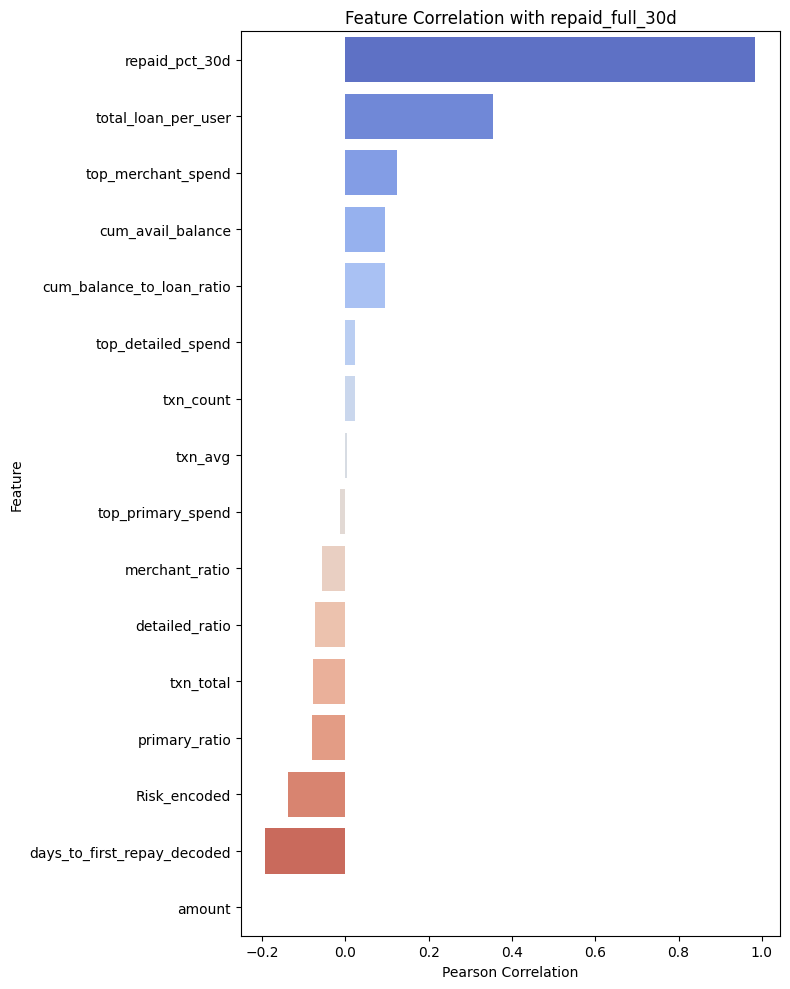

In [48]:
# Correlati matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = mg.copy()


df['repaid_full_30d'] = df['repaid_full_30d'].replace(
    {True: 1, False: 0, 'TRUE': 1, 'FALSE': 0, 'True': 1, 'False': 0}
).astype(float)

#  Identify numeric columns (including target encodings) ---
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the target itself from the list of predictors
if 'repaid_full_30d' in numeric_cols:
    numeric_cols.remove('repaid_full_30d')

print(f"Analyzing {len(numeric_cols)} numeric features for correlation with repayment...")

# Compute Pearson correlation for each feature with target ---
corr_values = (
    df[numeric_cols + ['repaid_full_30d']]
    .corr(numeric_only=True)['repaid_full_30d']
    .drop('repaid_full_30d')
    .sort_values(ascending=False)
)

# Print ranked list ---
print("\n=== Correlation of each feature with repaid_full_30d ===\n")
print(corr_values)

# Optional: visualize ---
plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_values.values,
    y=corr_values.index,
    orient='h',
    palette='coolwarm'
)
plt.title('Feature Correlation with repaid_full_30d')
plt.xlabel('Pearson Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
